Reference: https://github.com/advaitsave/Introduction-to-Time-Series-forecasting-Python/blob/master/Time%20Series%20in%20Python.ipynb

# Setup

In [ ]:
import warnings
import itertools
import os
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

!pip install statsmodels --upgrade

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
!pip install pmdarima
from pmdarima.arima import auto_arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

     |████████████████████████████████| 9.5MB 26.3MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2
     |████████████████████████████████| 1.5MB 32.4MB/s 


# Import Dataset

## For Desktop

In [ ]:
# wanliu = pd.read_csv('/Users/isabellachittumuri/Desktop/Projects/STAT 715/PRSA_Data_Wanliu_20130301-20170228.csv')

## select columns
# wanliu = wanliu[["year", "month", "day", "hour", "PM2.5"]]

## into datetime
# wanliu['Datetime']=pd.to_datetime(wanliu[['year','month','day', 'hour']])

## keep only 2 columns
# wanliu = wanliu[["Datetime", "PM2.5"]]

## sort by date & time
# wanliu['Datetime'] = pd.to_datetime(wanliu['Datetime'])
# wanliu.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
# wanliu.reset_index(inplace=True, drop=True)

## display the first couple of rows
# wanliu.head()


## For Google Drive

In [ ]:
# Mount drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# Data Preprocessing

In [ ]:
# let's only read one of the region's power consumptions, to keep this notebook concise
wanliu = pd.read_csv('/content/drive/MyDrive/715_project/PRSA_Data_Wanliu_20130301-20170228.csv', header=0, index_col=0, squeeze=True)

# select columns
wanliu = wanliu[["year", "month", "day", "hour", "PM2.5"]]

# into datetime
wanliu['Datetime']=pd.to_datetime(wanliu[['year','month','day', 'hour']])

# keep only 2 columns
wanliu = wanliu[["Datetime", "PM2.5"]]

# sort by date & time
wanliu['Datetime'] = pd.to_datetime(wanliu['Datetime'])
wanliu.sort_values(by=['Datetime'], axis=0, ascending=True, inplace=True)
wanliu.reset_index(inplace=True, drop=True)

# display the first couple of rows
wanliu.head()

,Datetime,PM2.5
0,2013-03-01 00:00:00,8.0
1,2013-03-01 01:00:00,9.0
2,2013-03-01 02:00:00,3.0
3,2013-03-01 03:00:00,11.0
4,2013-03-01 04:00:00,3.0


In [ ]:
wanliu.describe()

,PM2.5
count,34682.000000
mean,83.374716
std,81.905568
min,2.000000
25%,23.000000
50%,59.000000
75%,116.000000
max,957.000000


In [ ]:
print('Time period start: {}\nTime period end: {}'.format(wanliu["Datetime"].min(),wanliu["Datetime"].max()))

Time period start: 2013-03-01 00:00:00
Time period end: 2017-02-28 23:00:00


In [ ]:
wanliu.columns

Index(['Datetime', 'PM2.5'], dtype='object')

In [ ]:
wanliu.shape

(35064, 2)

In [ ]:
# check if there are duplicates
boolean = wanliu.duplicated().any() # False
boolean = wanliu.duplicated(subset=['Datetime','PM2.5']).any()
print(boolean)

False


False here - no duplicates row-wise 

In [ ]:
# convert the column (it's a string) to datetime type
datetime_series = pd.to_datetime(wanliu['Datetime'])

# create datetime index passing the datetime series
datetime_index = pd.DatetimeIndex(datetime_series.values)

df=wanliu.set_index(datetime_index)

# we don't need the column anymore
df.drop('Datetime',axis=1,inplace=True)

print(df.index)

DatetimeIndex(['2013-03-01 00:00:00', '2013-03-01 01:00:00', '2013-03-01 02:00:00', '2013-03-01 03:00:00', '2013-03-01 04:00:00', '2013-03-01 05:00:00', '2013-03-01 06:00:00', '2013-03-01 07:00:00', '2013-03-01 08:00:00', '2013-03-01 09:00:00',
               ...
               '2017-02-28 14:00:00', '2017-02-28 15:00:00', '2017-02-28 16:00:00', '2017-02-28 17:00:00', '2017-02-28 18:00:00', '2017-02-28 19:00:00', '2017-02-28 20:00:00', '2017-02-28 21:00:00', '2017-02-28 22:00:00', '2017-02-28 23:00:00'], dtype='datetime64[ns]', length=35064, freq=None)


## Fill Missing Values

In [ ]:
# Count total NaN in a DataFrame
print(" \nCount total NaN in a DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 382


In [ ]:
# uninterruped custom date range
date_range = pd.date_range(start=min(df.index), 
                           end=max(df.index), 
                           freq='H')

# this will append the previously missing datetimes, and create null values in our target variable
df = df.reindex(date_range)

# we fill in the blanks with values that lie on a linear curve between existing data points
df['PM2.5'].interpolate(method='linear', inplace=True)

# now we have a neatly continuous datetime index
print(f'The df.index.freq is now: {df.index.freq}, indicating that we no longer have missing instances')

The df.index.freq is now: <Hour>, indicating that we no longer have missing instances


In [ ]:
# check is any missing values left
print(" \nCount total NaN in a DataFrame : \n\n",
       df.isnull().sum().sum())

 
Count total NaN in a DataFrame : 

 0


## Create Df Copy

In [ ]:
df_copy =  df
df_copy.head()

,PM2.5
2013-03-01 00:00:00,8.0
2013-03-01 01:00:00,9.0
2013-03-01 02:00:00,3.0
2013-03-01 03:00:00,11.0
2013-03-01 04:00:00,3.0


# Exploratory data analysis

## Density Plot and Histogram 

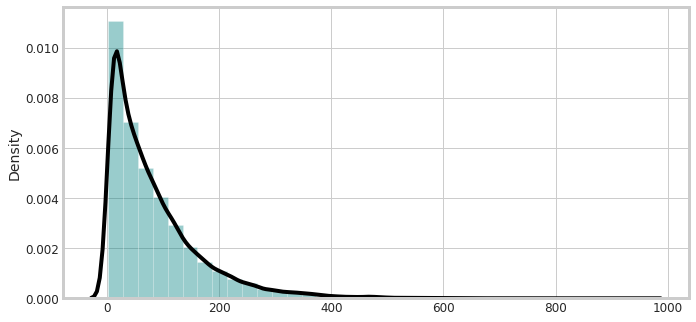

In [ ]:
# Density Plot and Histogram of all PM2.5 emissions
sns.set_style("whitegrid")  # Setting style(Optional)
plt.figure(figsize = (10,5)) #Specify the size of figure we want(Optional)
sns.distplot(x = df["PM2.5"]  ,  bins = int(180/5) , kde = True , color = 'teal'\
             , kde_kws=dict(linewidth = 4 , color = 'black'))
plt.show()

- The distribution is not Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

## Box and Whisker Plots

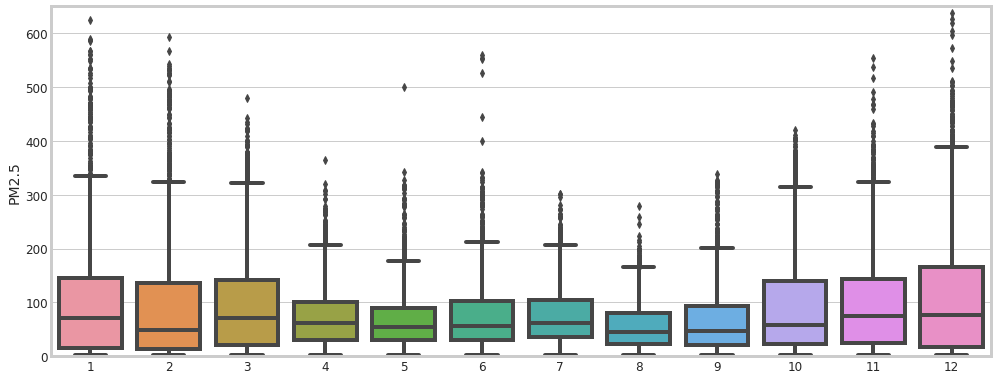

In [ ]:
# PM2.5 per month
fig, ax = plt.subplots(figsize=(15,6))
ax.set(ylim=(0,650))
sns.boxplot(data = df, x=df.index.month, y='PM2.5', ax=ax)

## Extracting Time Features


We can split up the date-timestamp column into its different components. This will allow us to find patterns for different groups.

In [ ]:
# see: https://www.kaggle.com/robikscube/starter-hourly-energy-consumption
df['dow'] = df.index.dayofweek
df['doy'] = df.index.dayofyear
df['year'] = df.index.year
df['month'] = df.index.month
df['quarter'] = df.index.quarter
df['hour'] = df.index.hour
df['weekday'] = df.index.day_name()
df['woy'] = df.index.weekofyear
df['dom'] = df.index.day # Day of Month
df['date'] = df.index.date 

# let's add the season number
df['season'] = df['month'].apply(lambda month_number: (month_number%12 + 3)//3)

## Plotting PM2.5 over time

In [ ]:
# plotly doesn't allow us to access the index, so let's copy it into a column 
df['date_and_time'] = df.index

# plotting
fig = px.line(df,
              x='date_and_time',
              y='PM2.5',
              title=f'Levels of PM2.5 over time [{min(df.year)} - {max(df.year)}]')
fig.update_traces(line=dict(width=1))
fig.update_layout(xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='PM2.5 (ug/m3)')
fig.show()

## Date & Time Patterns

### Hourly Weekday Patterns

In [ ]:
# aggregated data
_ = df\
    .groupby(['hour', 'weekday'], as_index=False)\
    .agg({'PM2.5':'max'})

# plotting
fig = px.line(_, 
              x='hour', 
              y='PM2.5', 
              color='weekday', 
              title='Max Hourly PM2.5 per Weekday')
fig.update_layout(xaxis_title='Hour',
                  yaxis_title='PM2.5')
fig.show()

In [ ]:
# aggregated data
_ = df\
    .groupby(['hour', 'weekday'], as_index=False)\
    .agg({'PM2.5':'median'})

# plotting
fig = px.line(_, 
              x='hour', 
              y='PM2.5', 
              color='weekday', 
              title='Median Hourly PM2.5 per Weekday')
fig.update_layout(xaxis_title='Hour',
                  yaxis_title='PM2.5')
fig.show()

### Hourly Seasonal Patterns

Season 1 = Winter
Season 2 = Spring
Season 3 = Summer
Season 4 = Fall

In [ ]:
# aggregated data
_ = df\
    .groupby(['hour', 'season'], as_index=False)\
    .agg({'PM2.5':'max'})

# plotting
fig = px.line(_,
              x='hour', 
              y='PM2.5', 
              color='season', 
              title='Max PM2.5 per Season')
fig.update_layout(xaxis_title='Hour',
                  yaxis_title='PM2.5')
fig.show()

In [ ]:
# aggregated data
_ = df\
    .groupby(['hour', 'season'], as_index=False)\
    .agg({'PM2.5':'median'})

# plotting
fig = px.line(_,
              x='hour', 
              y='PM2.5', 
              color='season', 
              title='Median PM2.5 per Season')
fig.update_layout(xaxis_title='Hour',
                  yaxis_title='PM2.5')
fig.show()

PM2.5 is highest during the winters

# Decomposing Time-Series

Trend - Consistent upwards or downwards slope of a time series

Seasonal - Clear periodic pattern of a time series(like sine funtion)

Noise - Outliers or missing values

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

# seasonal_decompose needs a dataframe with a datetime index
series = df[['PM2.5']]
frequency = 24*365

# decomposing the time-series, with the frequency being 24 hours per 365 days
decomposed = seasonal_decompose(series, model='additive', freq=frequency)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


NameError: ignored

In [ ]:
# plotting the different elements constituting our time-series
def plot_decompositions(decompositions, titles, line_widths):
    for d, t, lw in zip(decompositions, titles, line_widths):
        
        # draw a line plot of the data
        fig = px.line(d,
              y=different['PM2.5'],
              title=t,
              height=300)
        
        # adjust line width
        fig.update_traces(line=dict(width=lw))
        
        # change layout of axes and the figure's margins 
        # to emulate tight_layout
        fig.update_layout(
            xaxis=dict(
                showticklabels=False,
                linewidth=1
            ),
            yaxis=dict(title=''),
            margin=go.layout.Margin(
                l=40, r=40, b=0, t=40, pad=0
            ),
        )
        
        # display
        fig.show()

# calling the function 
plot_decompositions(decompositions=[decomposed.observed,
                                    decomposed.trend, 
                                    decomposed.seasonal, 
                                    decomposed.resid],
                    titles=['Observed',
                            'Trend', 
                            'Seasonality',
                            'Residuals'],
                    line_widths=[1, 2, 1, 1])

ValueError: ignored

- There is clearly an downward trend in the above plot.
- You can also see the uniform seasonal change.
- Non-uniform noise that represent outliers and missing values

# Test Stationarity

A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.

## Rolling Statistics

We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.

In [ ]:
#Determing rolling statistics
def TestStationaryStats(ts):
    rol_mean = ts.rolling(window = 12, center = False).mean()
    rol_std = ts.rolling(window = 12, center = False).std()
    
    plt.plot(ts, color = 'blue',label = 'Original Data')
    plt.plot(rol_mean, color = 'red', label = 'Rolling Mean')
    plt.plot(rol_std, color ='black', label = 'Rolling Std')
    plt.xticks(fontsize = 10)
    plt.yticks(fontsize = 10)
    
    plt.xlabel('Time in Years', fontsize = 10)
    plt.ylabel('Total Emissions', fontsize = 10)
    plt.legend(loc='best', fontsize = 10)
    plt.title('Rolling Mean & Standard Deviation', fontsize = 10)
    plt.show(block= True)

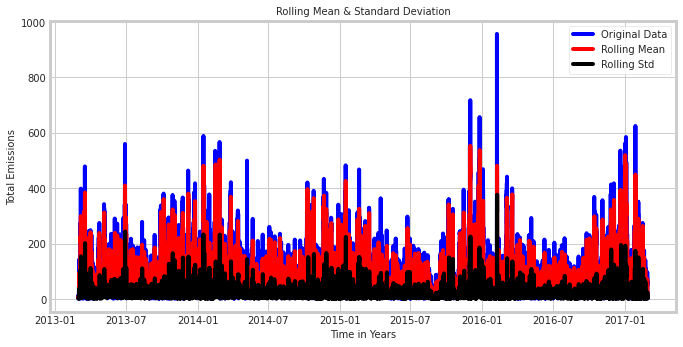

In [ ]:
plt.figure(figsize = (10,5))
TestStationaryStats(df['PM2.5'])

## ACF and PACF plots
Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots: 
- If the time series is stationary, the ACF/PACF plots will show a quick drop-off in correlation after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values.
- Confidence intervals are drawn as a cone.
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

Autocorrelation - The autocorrelation function (ACF) measures how a series is correlated with itself at different lags.

Partial Autocorrelation - The partial autocorrelation function can be interpreted as a regression of the series against its past lags. The terms can be interpreted the same way as a standard linear regression, that is the contribution of a change in that particular lag while holding others constant.

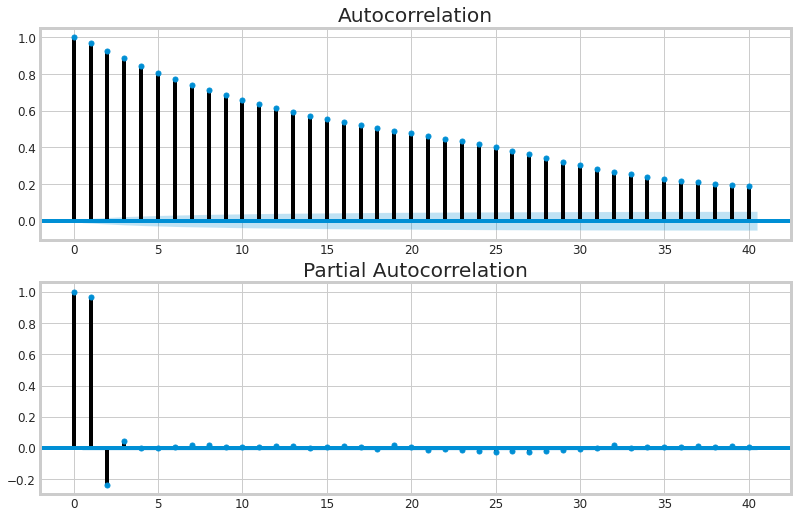

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df["PM2.5"].iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df["PM2.5"].iloc[13:], lags=40, ax=ax2)

## Augmented Dickey-Fuller Test

This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

For a Time series to be stationary, its ADCF test should have:

1. p-value to be low (according to the null hypothesis)
2. The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

In [ ]:
#Perform Augmented Dickey–Fuller test:
def TestStationaryAdfuller(ts):
    print('Results of Dickey Fuller Test:')
    
    ts_test = adfuller(ts, autolag = 'AIC')
    ts_test_output = pd.Series(ts_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in ts_test[4].items():
        ts_test_output['Critical Value (%s)'%key] = value
    print(ts_test_output)

In [ ]:
TestStationaryAdfuller(df["PM2.5"])

Results of Dickey Fuller Test:
Test Statistic                   -18.926629
p-value                            0.000000
#Lags Used                        51.000000
Number of Observations Used    35012.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64


From the above ADCF test result, we see that p-value is very low. However critical values are no where close to the Test Statistics. Hence, we can safely say that our Time Series at the moment is not stationary

## Kwiatkowski-Phillips-Schmidt-Shin (“KPSS”)

KPSS is another test for checking the stationarity of a time series. The null and alternate hypothesis for the KPSS test are opposite that of the ADF test.

Null Hypothesis: The process is trend stationary.

Alternate Hypothesis: The series has a unit root (series is not stationary).

In [ ]:
# KPSS test:
def TestStationaryKPSS(series, **kw):    
    statistic, p_value, n_lags, critical_values = kpss(series, **kw)
    # Format Output
    print(f'KPSS Statistic: {statistic}')
    print(f'p-value: {p_value}')
    print(f'num lags: {n_lags}')
    print('Critial Values:')
    for key, value in critical_values.items():
        print(f'   {key} : {value}')
    print(f'Result: The series is {"not " if p_value < 0.05 else ""}stationary')

In [ ]:
TestStationaryKPSS(df["PM2.5"])

KPSS Statistic: 0.9721619126615032
p-value: 0.01
num lags: 52
Critial Values:
   10% : 0.347
   5% : 0.463
   2.5% : 0.574
   1% : 0.739
Result: The series is not stationary


# Remove Seasonality and Trend 

Making Series Stationary

There are 2 major reasons behind non-stationaruty of a TS:

- Trend – varying mean over time. In this case we saw that on average, PM2.5 emissions was decreasing over time. 
- Seasonality – variations at specific time-frames. In this case, PM2.5 emission greatly increase during the winter seasons

## Regular Differencing

- In this technique, we take the difference of the observation at a particular instant with that at the previous instant.
- First order differencing in Pandas

In [ ]:
ts_first_diff = df["PM2.5"] - df["PM2.5"].shift(1)

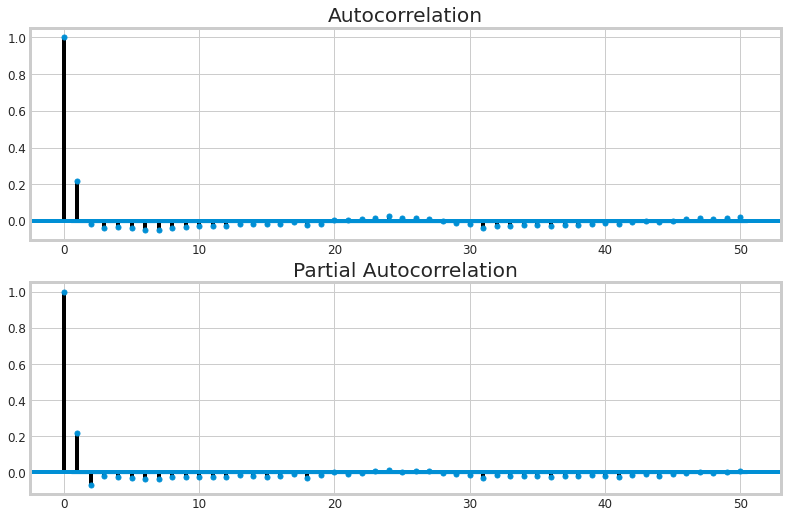

In [ ]:
ts_first_diff.dropna(inplace=True)
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_first_diff.iloc[13:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_first_diff.iloc[13:], lags=50, ax=ax2)

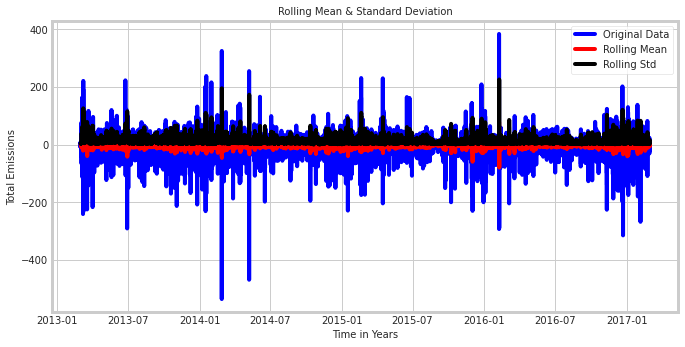

Results of Dickey Fuller Test:
Test Statistic                   -37.544751
p-value                            0.000000
#Lags Used                        44.000000
Number of Observations Used    35018.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64


In [ ]:
plt.figure(figsize = (10,5))
TestStationaryStats(ts_first_diff)
TestStationaryAdfuller(ts_first_diff)

## Seasonal Differencing


In [ ]:
# The seasonal difference
ts_seasonal_diff_12 = df["PM2.5"] - df["PM2.5"].shift(12)
ts_seasonal_diff_12.dropna(inplace=True)

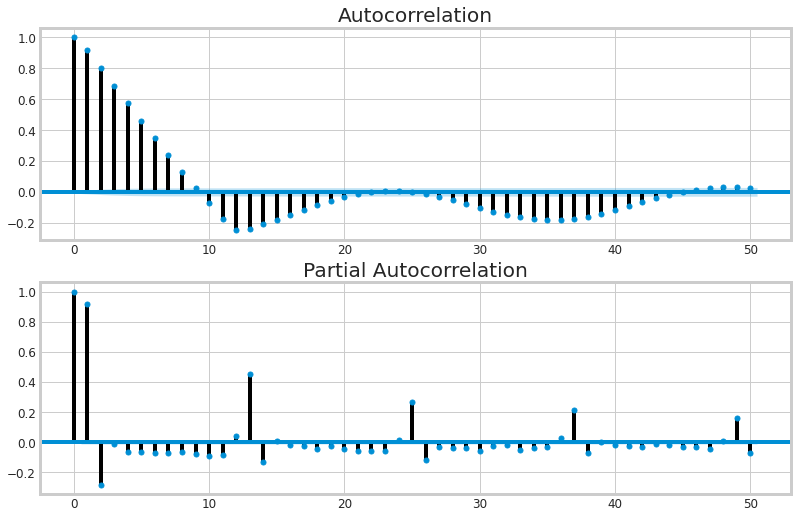

In [ ]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_seasonal_diff_12.iloc[13:], lags=50, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_seasonal_diff_12.iloc[13:], lags=50, ax=ax2)

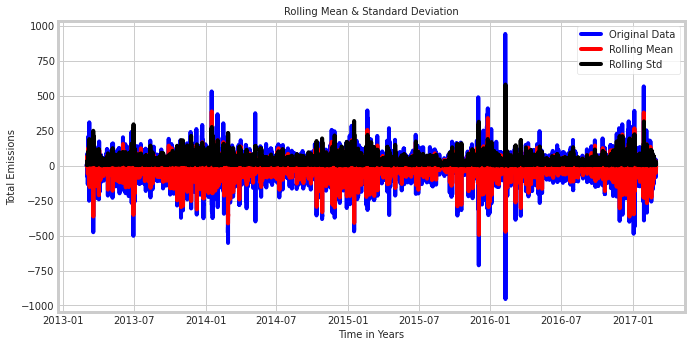

Results of Dickey Fuller Test:
Test Statistic                   -32.039637
p-value                            0.000000
#Lags Used                        52.000000
Number of Observations Used    34999.000000
Critical Value (1%)               -3.430537
Critical Value (5%)               -2.861623
Critical Value (10%)              -2.566814
dtype: float64


In [ ]:
plt.figure(figsize = (10,5))
TestStationaryStats(ts_seasonal_diff_12)
TestStationaryAdfuller(ts_seasonal_diff_12)

# Time Series forecasting

## Train/Test Split

Train = 70% of data (from 2013-2015, 24864 observations)

Test = 30% of data (from 2016-2017, 10200 observations)

In [ ]:
train_start,train_end = '2013-03-01','2015-12-31'
test_start,test_end = '2016-01-01','2017-02-28'

train_set = df_copy[train_start:train_end].dropna()
test_set = df_copy[test_start:test_end].dropna()

In [ ]:
print(train_set.count())
print(test_set.count())

PM2.5    24864
dtype: int64
PM2.5    10200
dtype: int64


In [ ]:
# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=train_set.index, y=train_set["PM2.5"],
                         mode='lines',
                         name='Training Data'))
fig.add_trace(go.Scatter(x=test_set.index, y=test_set["PM2.5"],
                         mode='lines', 
                         name='Validation Data'))

# adjust layout
fig.update_traces(line=dict(width=0.5))
fig.update_layout(title='Train/Valid Split',
                  xaxis_title='Date & Time (yyyy/mm/dd)',
                  yaxis_title='PM2.5 (ug/m3)')

## Error Definitions

In [ ]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [ ]:
def mape(y_true, y_pred):
    """ Mean Absolute Percentage Error """
    
    # convert to numpy arrays
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    
    # take the percentage error
    pe = (y_true - y_pred) / y_true
    
    # take the absolute values
    ape = np.abs(pe)
    
    # quantify the performance in a single number
    mape = np.mean(ape)
    
    return f'{mape*100:.2f}%'

# Autoregressive Integrated Moving Average (ARIMA)


Observations from EDA on the time series:

- Non stationarity implies at least one level of differencing (d) is required in ARIMA

ACF and PACF plots after differencing:

- AR(1) process -- PACF cut off at lag=1
- AR(2) process -- PACF cut off at lag=2
- MA(1) process -- ACF cut off at lag=1
- MA(2) process -- ACF cut off at lag=2

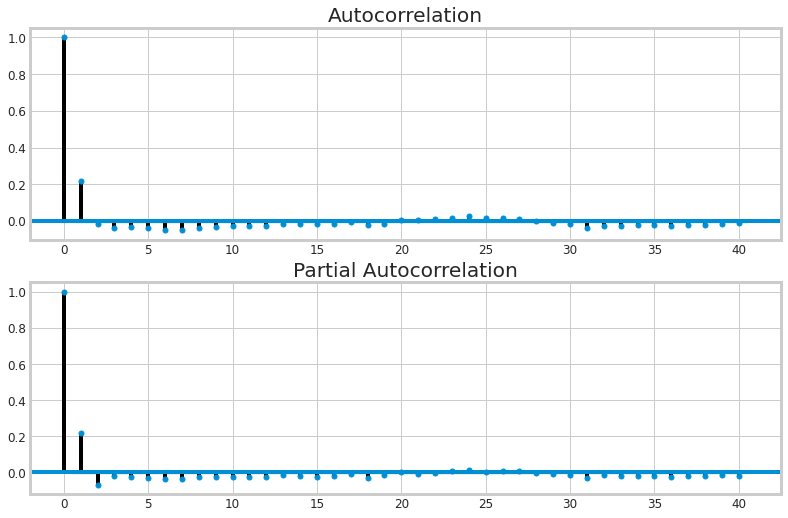

In [ ]:
# Recall First Differenced Series
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts_first_diff.iloc[13:], lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts_first_diff.iloc[13:], lags=40, ax=ax2)

In this case,
- AR(2) process -- has ACF tailing out and PACF cutting off at lag=2
- MA(1) process -- has ACF cut off at lag=1

So p=2, d=1, q=1

Plotting ARIMA model


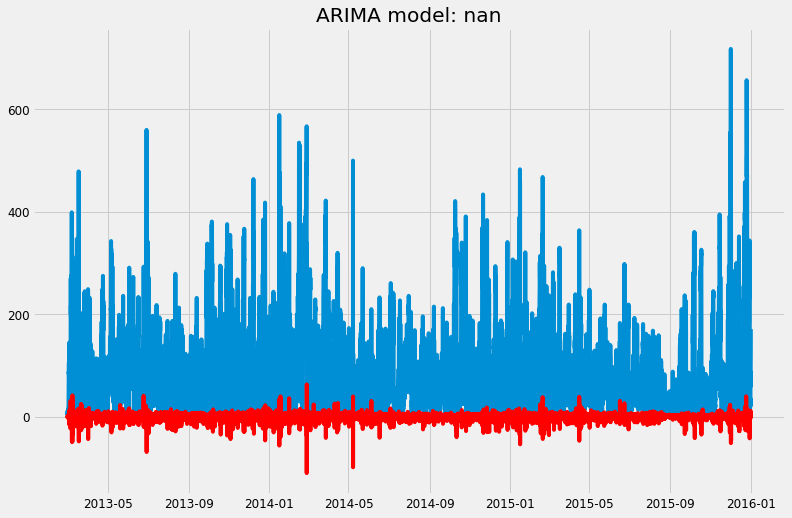

In [ ]:
# AR+I+MA = ARIMA model
model = ARIMA(train_set["PM2.5"], order=(2,1,1))
results_ARIMA = model.fit(disp=-1)

plt.figure(figsize=(12,8))
plt.plot(train_set["PM2.5"])
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('ARIMA model: %.4f'%sum((results_ARIMA.fittedvalues - train_set["PM2.5"])**2))
print('Plotting ARIMA model')

## Auto ARIMA

In [ ]:
#building the model
model = auto_arima(train_set,start_p=0,d=1,start_q=0,max_p=5,max_d=5,max_q=5, trace=True, 
                   error_action='ignore', suppress_warnings=True)
model.fit(train_set)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=220464.246, Time=0.77 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=219495.146, Time=0.92 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=219427.729, Time=2.83 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=220462.249, Time=0.30 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=219429.430, Time=5.23 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=219429.330, Time=3.88 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=44.73 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=219425.730, Time=0.89 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=219427.432, Time=1.63 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=219427.332, Time=1.44 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=219493.148, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=inf, Time=11.08 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0]          
Total fit time: 74.131 seconds


ARIMA(maxiter=50, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args={}, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=False)

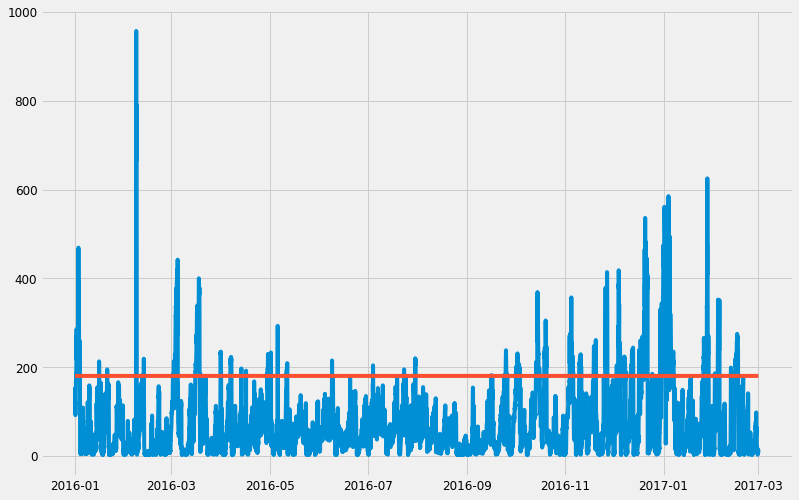

In [ ]:
forecast = model.predict(n_periods=len(test_set))
forecast = pd.DataFrame(forecast,index = test_set.index,columns=['Prediction'])

plt.figure(figsize=(12,8))
#plot the predictions for validation set
plt.plot(test_set["PM2.5"], label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

## Grid Search for Parameters

In [ ]:
from itertools import product

# setting initial values and some bounds for them
ps = range(0, 5)
d = range(0, 2)
qs = range(0, 5)

# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs)
parameters_list = list(parameters)
len(parameters_list)

50

In [ ]:
from tqdm import tqdm_notebook
def optimizeSARIMA(y, parameters_list):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], param[1], param[2])).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(df_copy["PM2.5"], parameters_list)


CPU times: user 13min 59s, sys: 9min 49s, total: 23min 49s
Wall time: 12min 14s


In [ ]:
result_table.head()

,parameters,aic
0,"(3, 1, 1)",307314.814188
1,"(1, 1, 3)",307315.007684
2,"(2, 1, 2)",307315.402238
3,"(4, 1, 1)",307316.511713
4,"(1, 1, 4)",307316.549934


In [ ]:
# set the parameters that give the lowest AIC
p, d, q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(df_copy["PM2.5"], order=(p, d, q)).fit(disp=-1)
print(best_model.summary())

                               SARIMAX Results                                
Dep. Variable:                  PM2.5   No. Observations:                35064
Model:               SARIMAX(3, 1, 1)   Log Likelihood             -153652.407
Date:                Tue, 04 May 2021   AIC                         307314.814
Time:                        22:36:21   BIC                         307357.139
Sample:                    03-01-2013   HQIC                        307328.294
                         - 02-28-2017                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.2074      0.001    894.181      0.000       1.205       1.210
ar.L2         -0.2889      0.002   -133.399      0.000      -0.293      -0.285
ar.L3          0.0447      0.002     27.771      0.0

In [ ]:
def plotARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted ARIMA model
        n_steps - number of steps to predict in the future    
    """
    s=0

    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['arima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['arima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.arima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['arima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

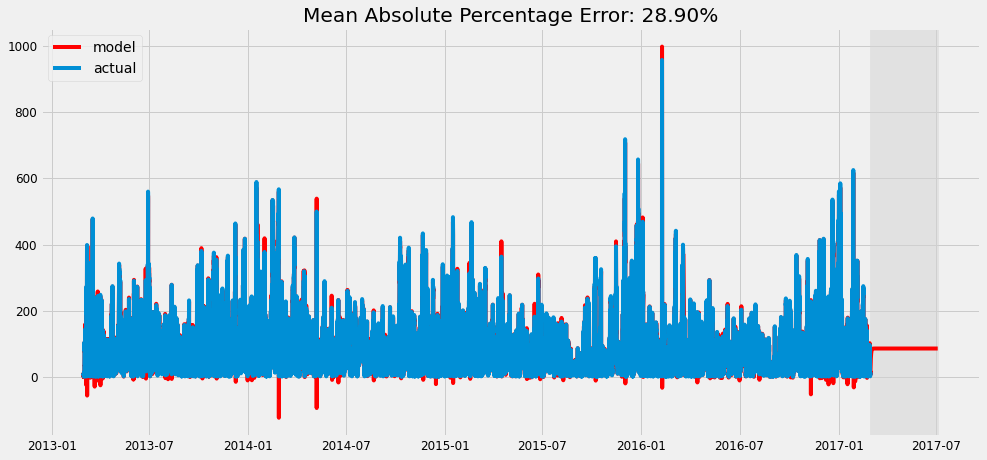

In [ ]:
plotARIMA(df_copy, best_model, 3000)

# Seasonal ARIMA (SARIMA)

Note: Auto arima does not work in python, it crashes

## Grid Search for Parameters

- p is most probably 2 since it is the last significant lag on the PACF, after which, most others are not significant.
- d is most probably 1 because we had first differences
- q is most probably 1 as well as seen on the ACF
- P might be 2, since 24-th and 48-th lags are somewhat significant on the PACF
- D again equals 1 because we performed seasonal differentiation
- Q is probably 1. The 24-th lag on ACF is significant while the 48-th is not

In [ ]:
from itertools import product

# setting initial values and some bounds for them
ps = range(0, 3)
d = range(0, 1)
qs = range(0, 2)
Ps = range(0, 2)
D = range(0, 2)
Qs = range(0, 2)
s = 12 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, d, qs, Ps, D, Qs)
parameters_list = list(parameters)
len(parameters_list)

48

In [ ]:
from tqdm import tqdm_notebook
def optimizeSARIMA(y, parameters_list, s):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], param[1], param[2]), 
                                            seasonal_order=(param[3], param[4], param[5], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [ ]:
%%time
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(train_set["PM2.5"], parameters_list, s)

In [ ]:
result_table.head()

Best model:  SARIMAX(2, 0, 1)x(0, 1, 1, 12)

AIC: 307178.211

In [ ]:
# set the parameters that give the lowest AIC
p, d, q, P, D, Q = result_table_12.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(train_set["PM2.5"], order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

In [ ]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

In [ ]:
plotSARIMA(test_set, best_model, 3000)

# Prophet

- Prophet is open source software released by Facebook's Core Data Science team.
- Prophet is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects.
- It works best with time series that have strong seasonal effects and several seasons of historical data.
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- The Prophet package provides intuitive parameters which are easy to tune.

In [ ]:
# https://facebook.github.io/prophet/docs/quick_start.html#python-api
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation

In [ ]:
# format data for prophet model using 'ds' and 'y'
train_prophet = train_set\
                    .reset_index()\
                    .rename(columns={
                        'index':'ds', 
                        'PM2.5':'y'
                    })

test_prophet = test_set\
                    .reset_index()\
                    .rename(columns={
                        'index':'ds',
                        'PM2.5':'y'
                    })

## Built-in Seasonality

In [ ]:
model = Prophet(yearly_seasonality=True)
model.fit(train_prophet)

# Predict on training set with model
forecast = model.predict(test_prophet)

SystemError: ignored

In [ ]:
# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_prophet.ds, y=test_prophet.y,
                         mode='lines',
                         name='Test - Actual'))
fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat,
                         mode='lines', 
                         name='Test - Forecast'))

# adjust layout
fig.update_traces(line=dict(width=0.5))
fig.update_layout(title='Prophet Forecast of Hourly PM2.5 Emissions',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='PM2.5 (ug/m3)')
fig.show()

# quantify accuracy
print(f'MAPE for Prophet\'s predictions: {mape(test_prophet.y, forecast.yhat)}')

In [ ]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width = 0.95, 
                   holidays = holidays)
my_model.fit(sales)

# dataframe that extends into future 6 weeks 
future_dates = my_model.make_future_dataframe(periods = 6*7)

print("First week to forecast.")
future_dates.tail(7)

# fitting the model
prophet.fit(train_prophet);

# part of the dataframe on which we want to make predictions
future = test_prophet.drop(['y'], axis=1)

# predicting values
forecast = prophet.predict(future)


## Custom Seasonality


In [ ]:
# conditions
def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

# adding to train set
train_prophet['is_spring'] = train_prophet['ds'].apply(is_spring)
train_prophet['is_summer'] = train_prophet['ds'].apply(is_summer)
train_prophet['is_autumn'] = train_prophet['ds'].apply(is_autumn)
train_prophet['is_winter'] = train_prophet['ds'].apply(is_winter)

# adding to test set
test_prophet['is_spring'] = test_prophet['ds'].apply(is_spring)
test_prophet['is_summer'] = test_prophet['ds'].apply(is_summer)
test_prophet['is_autumn'] = test_prophet['ds'].apply(is_autumn)
test_prophet['is_winter'] = test_prophet['ds'].apply(is_winter)

In [ ]:
# instantiating the class with custom settings, for the sake of illustration
prophet = Prophet(
     daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
)

# custom seasonalities to account for conditional variance 
# (more extreme trends in extreme seasons)
prophet.add_seasonality(name='yearly', period=365.25, fourier_order=10)
prophet.add_seasonality(name='weekly_spring', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_spring')
prophet.add_seasonality(name='weekly_summer', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_summer')
prophet.add_seasonality(name='weekly_autumn', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_autumn')
prophet.add_seasonality(name='weekly_winter', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_winter')
prophet.add_seasonality(name='daily_spring',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_spring')
prophet.add_seasonality(name='daily_summer',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_summer')
prophet.add_seasonality(name='daily_autumn',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_autumn')
prophet.add_seasonality(name='daily_winter',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_winter')

# account for holidays
#prophet.add_country_holidays(country_name='US')

# fitting the model
prophet.fit(train_prophet);

# part of the dataframe on which we want to make predictions
future = test_prophet.drop(['y'], axis=1)

# predicting values
forecast = prophet.predict(future)

In [ ]:
# create figure
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_prophet.ds, y=test_prophet.y,
                         mode='lines',
                         name='Test - Ground Truth'))
fig.add_trace(go.Scatter(x=forecast.ds, y=forecast.yhat,
                         mode='lines', 
                         name='Test - Prediction'))

# adjust layout
fig.update_traces(line=dict(width=0.5))
fig.update_layout(title='Prophet Forecast of Hourly Energy Demand',
                  xaxis_title='Date & Time (yyyy/mm/dd hh:MM)',
                  yaxis_title='Energy Demand [MW]')
fig.show()

# quantify accuracy
print(f'MAPE for Prophet\'s predictions: {mape(test_prophet.y, forecast.yhat)}')

MAPE for Prophet's predictions: 1145.48%


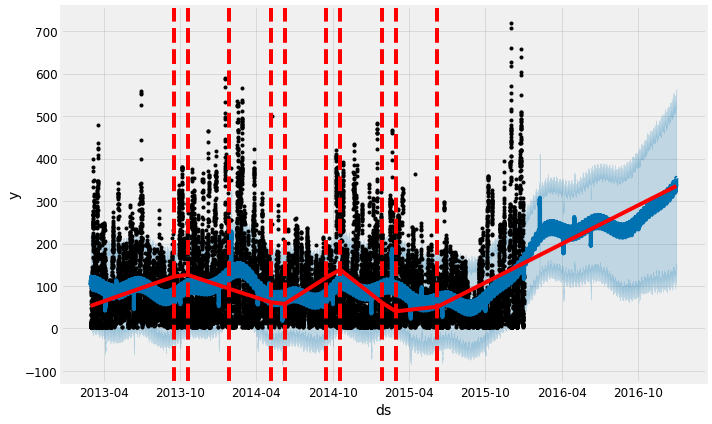

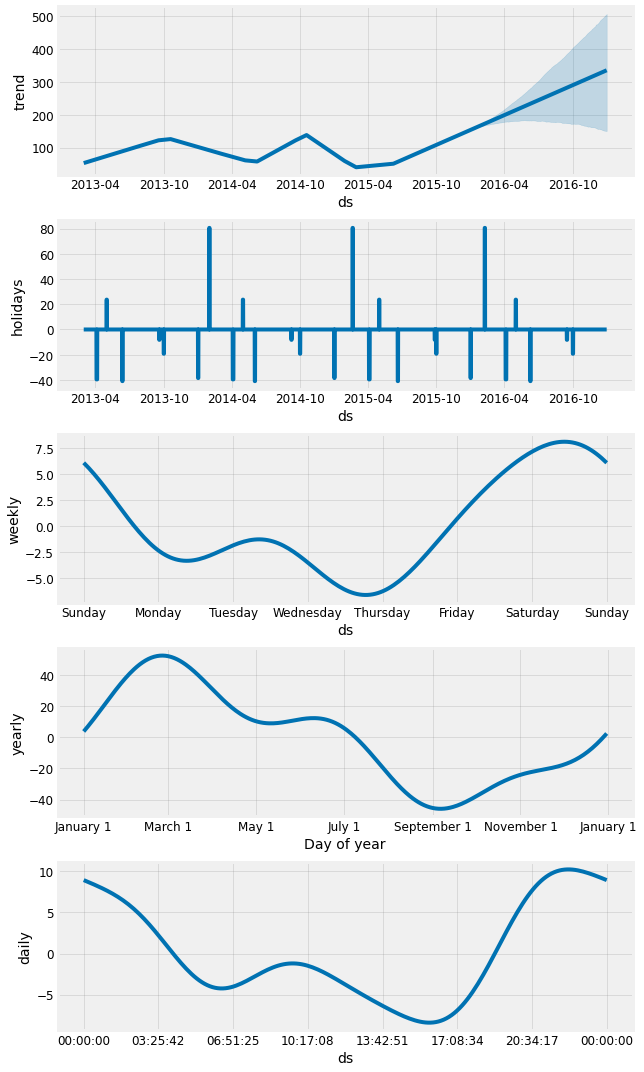

In [ ]:
from fbprophet.plot import add_changepoints_to_plot
prophet = Prophet(yearly_seasonality=False,
                  daily_seasonality=True,
                  seasonality_mode='additive',
                  changepoint_prior_scale=.05
                 ).add_seasonality(name='yearly',
                                   period=365.25,
                                   fourier_order=3,
                                   prior_scale=10,
                                   mode='additive')

prophet.add_country_holidays(country_name='China')
prophet.fit(train_prophet[train_prophet['ds'] < pd.to_datetime('2017')])
future = prophet.make_future_dataframe(periods=365 * 24, freq='H')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
plt.show()
fig2 = prophet.plot_components(forecast)
plt.show()